<a href="https://colab.research.google.com/github/Sadvi03/Parkinsions-prediction-using-hand-drawn-spiral-images/blob/main/Parkinson's_Disease_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Parkinson's Disease Detection using Parkinson's Spiral Drawing and CNN

![](https://cainvas-static.s3.amazonaws.com/media/user_data/Yuvnish17/Parkinsons-Disease.png)

### Cloning GitHub Repository for dataset

In [ ]:
! git clone https://github.com/Yuvnish017/Parkinsons_Disease_Detection_using_Parkinsons_Spiral_Drawing.git

Cloning into 'Parkinsons_Disease_Detection_using_Parkinsons_Spiral_Drawing'...
remote: Enumerating objects: 26, done.
remote: Total 26 (delta 0), reused 0 (delta 0), pack-reused 26 (from 1)
Receiving objects: 100% (26/26), 11.41 MiB | 15.46 MiB/s, done.
Resolving deltas: 100% (7/7), done.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Importing the required Libraries and packages

In [ ]:
import numpy as np
import cv2
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Dropout, Flatten, Dense, MaxPool2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.optimizers import Adam, SGD
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from tensorflow.keras.regularizers import l2
import tensorflow as tf
import pandas as pd

### Loading Dataset

In [ ]:
data_train = np.load('/content/drive/MyDrive/Dataset/train_set.npz', allow_pickle=True)
x_train = data_train['arr_0']
y_train = data_train['arr_1']

print(x_train.shape)
print(y_train.shape)

(72, 256, 256, 3)
(72,)


In [ ]:
data_test = np.load('/content/drive/MyDrive/Dataset/test_set.npz', allow_pickle=True)
x_test = data_test['arr_0']
y_test = data_test['arr_1']

print(x_test.shape)
print(y_test.shape)

(30, 256, 256, 3)
(30,)


### Data Distribution

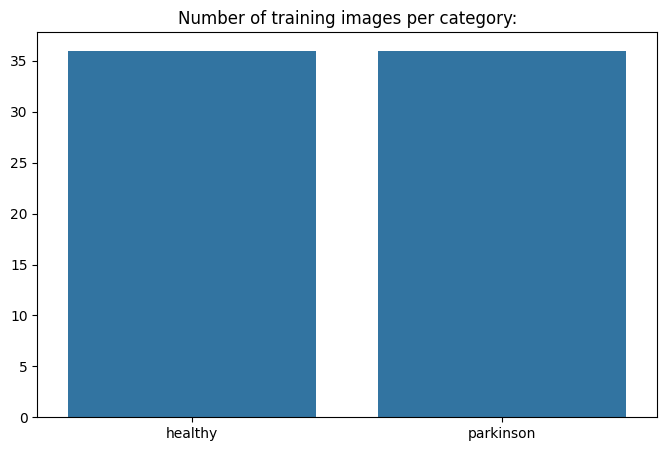

In [ ]:
unique_train, count = np.unique(y_train, return_counts=True)
plt.figure(figsize=(8,5))
sns.barplot(x=unique_train, y=count).set_title("Number of training images per category:")
plt.show()

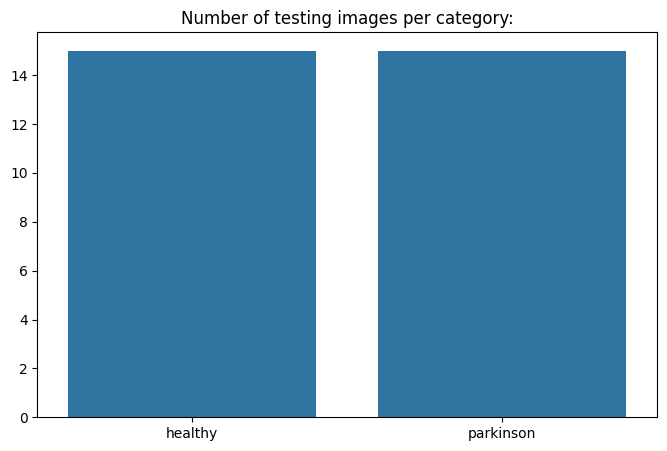

In [ ]:
unique_test, count_test = np.unique(y_test, return_counts=True)
plt.figure(figsize=(8, 5))
sns.barplot(x=unique_test,y=count_test).set_title("Number of testing images per category:")
plt.show()

As can be seen, though the dataset is balanced but contains very less data points

### Augmenting the Dataset

In [ ]:
train_data_generator = ImageDataGenerator(rotation_range=360,
                                    width_shift_range=0.0,
                                    height_shift_range=0.0,
                                    horizontal_flip=True,
                                    vertical_flip=True)

x = list(x_train)
y = list(y_train)

x_aug_train = []
y_aug_train = []

for (i, v) in enumerate(y):
    x_img = x[i]
    x_img = np.array(x_img)
    x_img = np.expand_dims(x_img, axis=0)
    aug_iter = train_data_generator.flow(x_img, batch_size=1, shuffle=True)
    for j in range(70):
        aug_image = next(aug_iter)[0].astype('uint8')
        x_aug_train.append(aug_image)
        y_aug_train.append(v)
print(len(x_aug_train))
print(len(y_aug_train))

x_train = x + x_aug_train
y_train = y + y_aug_train
print(len(x_train))
print(len(y_train))

test_data_generator = ImageDataGenerator(rotation_range=360,
                                    width_shift_range=0.0,
                                    height_shift_range=0.0,
                                    horizontal_flip=True,
                                    vertical_flip=True)

x = list(x_test)
y = list(y_test)

x_aug_test = []
y_aug_test = []

for (i, v) in enumerate(y):
    x_img = x[i]
    x_img = np.array(x_img)
    x_img = np.expand_dims(x_img, axis=0)
    aug_iter = test_data_generator.flow(x_img, batch_size=1, shuffle=True)
    for j in range(20):
        aug_image = next(aug_iter)[0].astype('uint8')
        x_aug_test.append(aug_image)
        y_aug_test.append(v)
print(len(x_aug_test))
print(len(y_aug_test))

x_test = x + x_aug_test
y_test = y + y_aug_test
print(len(x_test))
print(len(y_test))

5040
5040
5112
5112
600
600
630
630


### Visualizing the Images in Train and Test Set

##### Images in Train Set

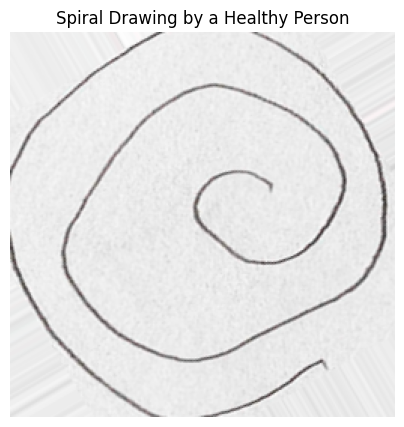

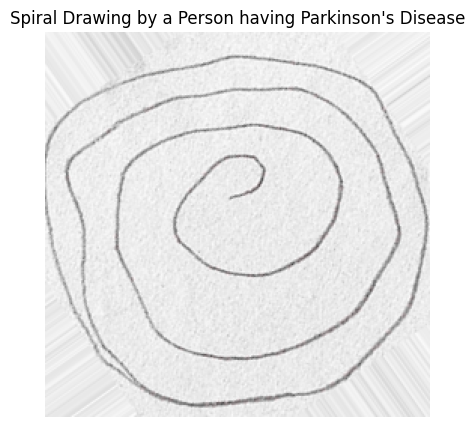

In [ ]:
# print(y_test)
figure1 = plt.figure(figsize=(5, 5))
idx_healthy = [i for (i, v) in enumerate(y_train) if v=='healthy']
img_healthy = x_train[idx_healthy[-1]]
plt.imshow(img_healthy)
plt.title('Spiral Drawing by a Healthy Person')
plt.axis('off')
plt.show()

figure2 = plt.figure(figsize=(5, 5))
idx_parkinson = [i for (i, v) in enumerate(y_train) if v=='parkinson']
img_parkinson = x_train[idx_parkinson[-1]]
plt.imshow(img_parkinson)
plt.title("Spiral Drawing by a Person having Parkinson's Disease")
plt.axis('off')
plt.show()

#### Images in Test Set

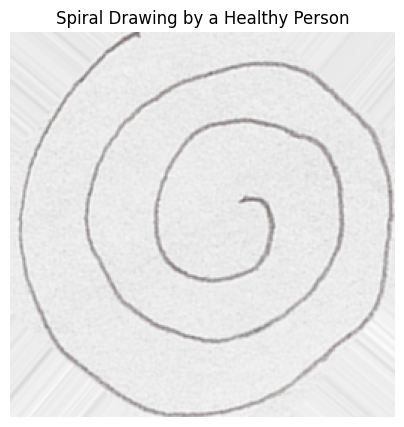

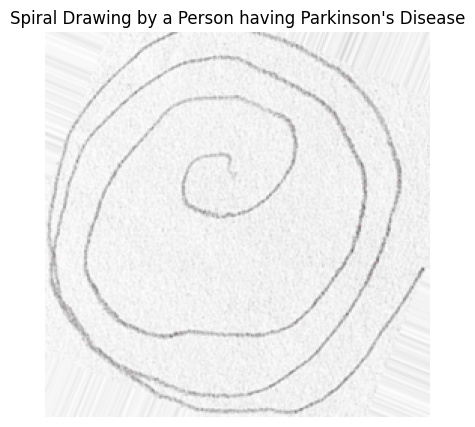

In [ ]:
figure1 = plt.figure(figsize=(5, 5))
idx_healthy = [i for (i, v) in enumerate(y_test) if v=='healthy']
img_healthy = x_test[idx_healthy[-1]]
plt.imshow(img_healthy)
plt.title('Spiral Drawing by a Healthy Person')
plt.axis('off')
plt.show()

figure2 = plt.figure(figsize=(5, 5))
idx_parkinson = [i for (i, v) in enumerate(y_test) if v=='parkinson']
img_parkinson = x_test[idx_parkinson[-1]]
plt.imshow(img_parkinson)
plt.title("Spiral Drawing by a Person having Parkinson's Disease")
plt.axis('off')
plt.show()

### Preprocessing the Images

In [ ]:
for i in range(len(x_train)):
    img = x_train[i]
    img = cv2.resize(img, (128, 128))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    x_train[i] = img

for i in range(len(x_test)):
    img = x_test[i]
    img = cv2.resize(img, (128, 128))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    x_test[i] = img

x_train = np.array(x_train)
x_test = np.array(x_test)

x_train = x_train/255.0
x_test = x_test/255.0

label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
print(y_train.shape)

label_encoder = LabelEncoder()
y_test = label_encoder.fit_transform(y_test)
print(y_test.shape)

(5112,)
(630,)


### Data Distribution after Augmentation

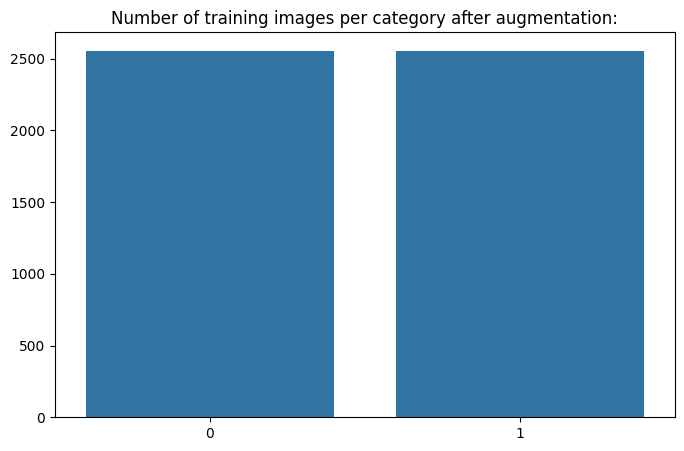

In [ ]:
unique_train, count = np.unique(y_train, return_counts=True)
plt.figure(figsize=(8,5))
sns.barplot(x=unique_train, y=count).set_title("Number of training images per category after augmentation:")
plt.show()

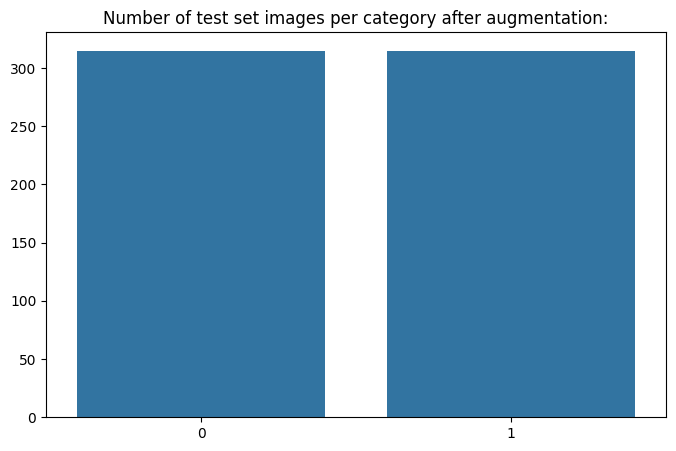

In [ ]:
unique_test, count_test = np.unique(y_test, return_counts=True)
plt.figure(figsize=(8,5))
sns.barplot(x=unique_test, y=count_test).set_title("Number of test set images per category after augmentation:")
plt.show()

In [ ]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(5112, 128, 128, 1)
(5112, 2)
(630, 128, 128, 1)
(630, 2)


### Defining the Model

In [ ]:
def parkinson_disease_detection_model(input_shape=(128, 128, 1)):
    regularizer = tf.keras.regularizers.l2(0.001)
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(Conv2D(128, (5, 5), padding='same', strides=(1, 1), name='conv1', activation='relu',
                     kernel_initializer='glorot_uniform', kernel_regularizer=regularizer))
    model.add(MaxPool2D((9, 9), strides=(3, 3)))

    model.add(Conv2D(64, (5, 5), padding='same', strides=(1, 1), name='conv2', activation='relu',
                     kernel_initializer='glorot_uniform', kernel_regularizer=regularizer))
    model.add(MaxPool2D((7, 7), strides=(3, 3)))

    model.add(Conv2D(32, (3, 3), padding='same', strides=(1, 1), name='conv3', activation='relu',
                     kernel_initializer='glorot_uniform', kernel_regularizer=regularizer))
    model.add(MaxPool2D((5, 5), strides=(2, 2)))

    model.add(Conv2D(32, (3, 3), padding='same', strides=(1, 1), name='conv4', activation='relu',
                     kernel_initializer='glorot_uniform', kernel_regularizer=regularizer))
    model.add(MaxPool2D((3, 3), strides=(2, 2)))

    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu', kernel_initializer='glorot_uniform', name='fc1'))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation='softmax', kernel_initializer='glorot_uniform', name='fc3'))

    optimizer = Adam(3.15e-5)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
model= parkinson_disease_detection_model(input_shape=(128, 128, 1))
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1 (Conv2D)                       │ (None, 128, 128, 128)       │           3,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 40, 40, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2 (Conv2D)                       │ (None, 40, 40, 64)          │         204,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 12, 12, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3 (Conv2D)                       │ (None, 12, 12, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 4, 4, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv4 (Conv2D)                       │ (None, 4, 4, 32)            │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 1, 1, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc1 (Dense)                          │ (None, 64)                  │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc3 (Dense)                          │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 238,146 (930.26 KB)

 Trainable params: 238,146 (930.26 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Save the model as cnn_model.h5
model.save('/content/cnn_model.h5')


### Training the Model

In [ ]:
hist = model.fit(x_train, y_train, batch_size=128, epochs=70, validation_data=(x_test, y_test))

Epoch 1/70
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 121ms/step - accuracy: 0.8948 - loss: 0.3646 - val_accuracy: 0.8619 - val_loss: 0.3866
Epoch 2/70
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 118ms/step - accuracy: 0.9018 - loss: 0.3569 - val_accuracy: 0.8556 - val_loss: 0.4215
Epoch 3/70
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 118ms/step - accuracy: 0.8887 - loss: 0.3652 - val_accuracy: 0.8667 - val_loss: 0.3995
Epoch 4/70
40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 139ms/step - accuracy: 0.9033 - loss: 0.3471 - val_accuracy: 0.8698 - val_loss: 0.3998
Epoch 5/70
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 121ms/step - accuracy: 0.8990 - loss: 0.3558 - val_accuracy: 0.8619 - val_loss: 0.4055
Epoch 6/70
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 115ms/step - accuracy: 0.9146 - loss: 0.3303 - val_accuracy: 0.8429 - val_loss: 0.4580
Epoch 7/70
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 120ms/step - accuracy: 0.9005 - loss: 0.3481 - val_accuracy: 0.8794 - val_loss: 0.3846
Epoch 8/70
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 113ms/step - accuracy: 0.9092 - loss: 0.3470 - val_accuracy: 0.

### Loss and Accuracy Plot

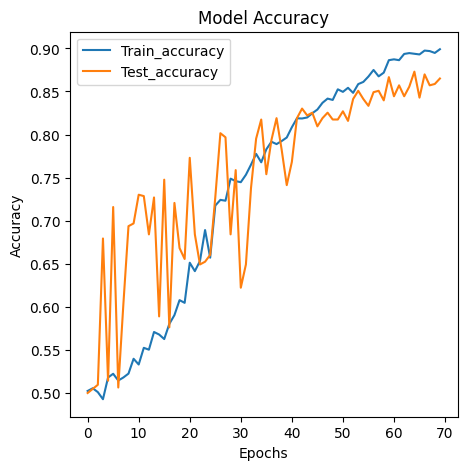

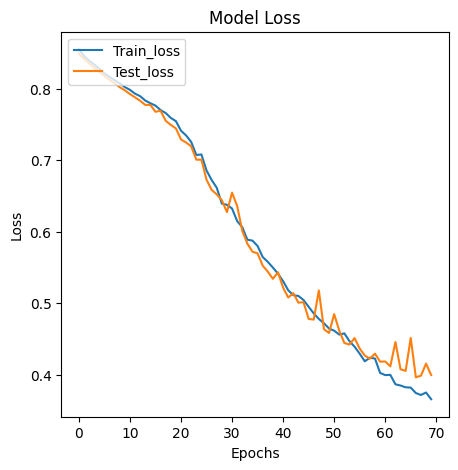

In [ ]:
figure = plt.figure(figsize=(5,5))
plt.plot(hist.history['accuracy'], label='Train_accuracy')
plt.plot(hist.history['val_accuracy'], label='Test_accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc="upper left")
plt.show()

figure2 = plt.figure(figsize=(5,5))
plt.plot(hist.history['loss'], label='Train_loss')
plt.plot(hist.history['val_loss'], label='Test_loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc="upper left")
plt.show()

### Classification Report

In [ ]:
ypred = model.predict(x_test)
ypred = np.argmax(ypred, axis=1)
y_test_pred = np.argmax(y_test, axis=1)
print(classification_report(y_test_pred, ypred))

20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step
              precision    recall  f1-score   support

           0       0.92      0.80      0.86       315
           1       0.82      0.93      0.87       315

    accuracy                           0.87       630
   macro avg       0.87      0.87      0.86       630
weighted avg       0.87      0.87      0.86       630



### Confusion Matrix

<Axes: >

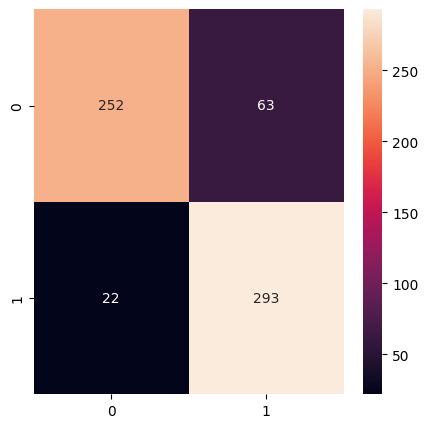

In [ ]:
matrix = confusion_matrix(y_test_pred, ypred)
df_cm = pd.DataFrame(matrix, index=[0, 1], columns=[0, 1])
figure = plt.figure(figsize=(5, 5))
sns.heatmap(df_cm, annot=True, fmt='d')

### Saving the Model

In [ ]:
model.save('parkinson_disease_detection.h5')

### Testing Model on Images

In [ ]:
labels = ['Healthy', 'Parkinson']
image_healthy = cv2.imread('/content/drive/MyDrive/Dataset/test_image_healthy.png')
image_parkinson = cv2.imread('/content/drive/MyDrive/Dataset/test_image_parkinson.png')

image_healthy = cv2.resize(image_healthy, (128, 128))
image_healthy = cv2.cvtColor(image_healthy, cv2.COLOR_BGR2GRAY)
image_healthy = np.array(image_healthy)
image_healthy = np.expand_dims(image_healthy, axis=0)
image_healthy = np.expand_dims(image_healthy, axis=-1)

image_parkinson = cv2.resize(image_parkinson, (128, 128))
image_parkinson = cv2.cvtColor(image_parkinson, cv2.COLOR_BGR2GRAY)
image_parkinson = np.array(image_parkinson)
image_parkinson = np.expand_dims(image_parkinson, axis=0)
image_parkinson = np.expand_dims(image_parkinson, axis=-1)

In [ ]:
ypred_healthy = model.predict(image_healthy)
ypred_parkinson = model.predict(image_parkinson)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 845ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


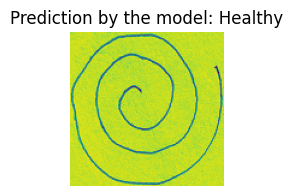

In [ ]:
figure = plt.figure(figsize=(2, 2))
img_healthy = np.squeeze(image_healthy, axis=0)
img_healthy = np.squeeze(img_healthy, axis=-1)
plt.imshow(img_healthy)
plt.axis('off')
plt.title(f'Prediction by the model: {labels[np.argmax(ypred_healthy[0], axis=0)]}')
plt.show()

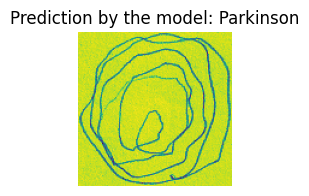

In [ ]:
figure = plt.figure(figsize=(2, 2))
image_parkinson = np.squeeze(image_parkinson, axis=0)
image_parkinson = np.squeeze(image_parkinson, axis=-1)
plt.imshow(image_parkinson)
plt.axis('off')
plt.title(f'Prediction by the model: {labels[np.argmax(ypred_parkinson[0], axis=0)]}')
plt.show()